# IFT6135-A2022
# Assignment 1: Practical

Vous devez remplir vos réponses dans ce Notebook, après quoi vous devez exporter ce Notebook vers un fichier Python nommé `solution.py` et le soumettre sur Gradescope.

N'éditez pas les fonctions spécifiées dans le PDF (et partout où cela est indiqué - `# WRITE CODE HERE`). Ne changez pas les définitions et ne modifiez pas le reste du modèle, sinon l'autograde ne fonctionnera pas.

**Assurez-vous de demander un runtime GPU (surtout pour la question 3) !**

In [2]:
# DO NOT MODIFY!
import matplotlib.pyplot as plt
import numpy as np
import random

# Fix random seed
random.seed(0)
np.random.seed(0)

## Question 1: Implementing MLPs with NumPy (30 points)

In [3]:
class NN(object):
  """
    Implements an MLP.
  """

  def __init__(self,
               dims=(784, 128, 64, 10), # h_0, h_1, h_2, h_3
               activation="relu",       # Activation function
               epsilon=1e-6,            # Correction factor
               lr=0.01,                 # Learning rate
               seed=0                   # Random seed
              ):
    """
      Constructor of the NN class.

      dims: list or tuple or np.array, default (784, 128, 64, 10)
        Valeurs de h_0 (nombre de caractéristiques), h_1 (dim. cachée 1), h_2 (dim. cachée 2), h_3 (nombre de classes de sortie).
      activation: string, default "relu"
        La fonction d'activation.
      epsilon: float or double, default 1e-6
        Facteur de correction des probabilités.
      lr: float or double, default 0.01
        Taux d'apprentissage.
      seed: int, default 0
        Random seed.
    """
    super(NN, self).__init__()

    self.dims = dims
    self.n_hidden = len(dims) - 2
    self.activation_str = activation
    self.epsilon = epsilon
    self.lr = lr
    self.seed = seed

  def initialize_weights(self):
    """
      Résultats : Initialise les weights du MLP à partir de uniform(-1/sqrt(h_0), 1/sqrt(h_0)) et les biais à zéro.
    """
    if self.seed is not None:
      np.random.seed(self.seed)

    self.weights = {}
    # self.weights is a dictionary with keys W1, b1, W2, b2, ..., Wm, Bm where m - 1 is the number of hidden layers
    # The keys W1, W2, ..., Wm correspond to weights while b1, b2, ..., bm correspond to biases
    for layer_n in range(1, self.n_hidden + 2):
      # WRITE CODE HERE
      self.weights[f"W{layer_n}"] = np.random.uniform(low = -1/np.sqrt(self.dims[0]), high = 1/np.sqrt(self.dims[0]), size = (self.dims[layer_n - 1], self.dims[layer_n]))
      self.weights[f"b{layer_n}"] = np.zeros((1, self.dims[layer_n]))

  def relu(self, x, grad=False):
    """
      x: np.array
        Entrées pour lesquelles calculer ReLU(x). x peut contenir un batch d'entrées !
      grad: bool, default False
        Si True, retourne le gradient de l'activation par rapport aux entrées de la fonction.

      Outputs: Implémente la fonction d'activation ReLU ou son gradient.
    """
    if grad:
      return (x > 0) * 1
    return np.maximum(0,x)

  def sigmoid(self, x, grad=False):
    """
      x: np.array
        Entrées pour lesquelles calculer sigmoid(x). x peut contenir un batch d'entrées !
      grad: bool, default False
        Si True, retourne le gradient de l'activation par rapport aux entrées de la fonction.

      Outputs: Implémente la fonction d'activation sigmoid ou son gradient.
    """
    if grad:
      return np.exp(-x)/(1 + np.exp(-x))**2
    return 1 / (1 + np.exp(-x)) 

  def tanh(self, x, grad=False):
    """
      x: np.array
        Entrées pour lesquelles calculer tanh(x). x peut contenir un batch d'entrées !
      grad: bool, default False
        Si True, retourne le gradient de l'activation par rapport aux entrées de la fonction.

      Outputs: Implémente la fonction d'activation tanh ou son gradient.
    """
    if grad:
      return 1 - ((1 - np.exp(-2*x))/(1 + np.exp(-2*x)))**2
    return (1 - np.exp(-2*x))/(1 + np.exp(-2*x))

  def activation(self, x, grad=False):
    """
      x: np.array
        Entrées pour calculer l'activation(x). x peut contenir un batch d'entrées !
      grad: bool, default False
        Si True, retourne le gradient de l'activation par rapport aux entrées de la fonction.

      Outputs: Retourne la valeur de l'activation ou le gradient.
    """
    if self.activation_str == "relu":
      return self.relu(x,grad)
    elif self.activation_str == "sigmoid":
      return self.sigmoid(x,grad)
    elif self.activation_str == "tanh":
      return self.tanh(x,grad)
    else:
      raise Exception("Invalid activation")

  def softmax(self, x):
    """
      x: np.array
        Entrées pour calculer le softmax. x peut contenir un batch d'entrées !

      Outputs: Implémente la fonction softmax, renvoie l'array contenant softmax(x).
    """
    # Remember that softmax(x-C) = softmax(x) when C is a constant.
    # WRITE CODE HERE
    res = np.array([])
    for i in range(x.shape[0]):
      res = np.append(res, np.exp(x[i] - np.max(x[i]))/np.sum(np.exp(x[i] - np.max(x[i]))))
    return res.reshape(x.shape)

  def forward(self, x):
    """
      x: np.array
        Entrées du MLP. Notez que x peut contenir plusieurs exemples d'entrée.

      Outputs: Implémente la passe forward, retourne le cache comme décrit ci-dessous.
    """
    cache = {"Z0": x}
    # le cache est un dictionnaire avec les clés Z0, A1, Z1, ..., Am, Zm où m - 1 est le nombre de couches cachées
    # Z0 contient juste les entrées x du réseau
    # Ai correspond à la préactivation de la couche i, Zi correspond à l'activation de la couche i
    for layer_n in range(1, self.n_hidden + 2):
      cache[f"A{layer_n}"] = np.dot(cache[f"Z{layer_n - 1}"], self.weights[f"W{layer_n}"]) + self.weights[f"b{layer_n}"]
      if layer_n == self.n_hidden + 1:
        cache[f"Z{layer_n}"] = self.softmax(cache[f"A{layer_n}"]) 
      else:
        cache[f"Z{layer_n}"] = self.activation(cache[f"A{layer_n}"])
    return cache

  def loss(self, prediction, labels):
    """
      prediction: np.array
        Probabilités prédites pour chaque classe pour les entrées. Peut contenir plusieurs exemples (un batch) !
      labels: np.array
        Vraies labels correspondant aux entrées (one-hot encoded). Peut contenir plusieurs exemples (un batch) !

      Outputs: Renvoie la perte de l'entropie croisée (moyenne sur le nombre d'entrées).
    """
    prediction[np.where(prediction < self.epsilon)] = self.epsilon
    prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
    return -np.mean(np.sum(labels * np.log(prediction), axis=1))

  def backward(self, cache, labels):
    """
      cache: np.array
        Résultats de la passe backward. Cela peut être pour plusieurs exemples (un batch).
      labels: np.array
        Vraies labels correspondant aux entrées dans le cache. Peut contenir plusieurs exemples (un batch) !

      Outputs: Implémente le backward pass, retourne les grads comme décrit ci-dessous.
    """
    output = cache[f"Z{self.n_hidden + 1}"]
    grads = {}

    # grads est un dictionnaire avec les clés dAm, dWm, dbm, dZ(m-1), dA(m-1), ..., dW1, db1
    # N'oubliez pas de prendre en compte le nombre d'exemples en entrée !
    for layer_n in range(self.n_hidden + 1, 0, -1):
      if layer_n == self.n_hidden + 1:
        grads[f"dA{layer_n}"] = output - labels
      else:
        grads[f"dA{layer_n}"] = grads[f"dZ{layer_n}"] * self.activation(cache[f"A{layer_n}"], grad=True)
      grads[f"dW{layer_n}"] = np.dot(cache[f"Z{layer_n - 1}"].T, grads[f"dA{layer_n}"]) / labels.shape[0]
      grads[f"db{layer_n}"] = grads[f"dA{layer_n}"].mean(axis=0, keepdims=True)
      if layer_n > 1:
        grads[f"dZ{layer_n - 1}"] = np.dot(grads[f"dA{layer_n}"], self.weights[f"W{layer_n}"].T)
    return grads

  def update(self, grads):
    """
      grads: np.dictionary
        Gradients obtenus à partir de la passe backward.

      Results: Met à jour les poids et les biais du réseau.
    """
    for layer in range(1, self.n_hidden + 2):
      self.weights[f"W{layer}"] -= self.lr * grads[f"dW{layer}"]
      self.weights[f"b{layer}"] -= self.lr * grads[f"db{layer}"]

## Question 2: Implementing CNN layers with NumPy (20 points)
Note: You may assume that there are no biases, no input padding (valid convolution) and also that convolution here refers to cross-correlation, i.e., no kernel flipping when convolving the inputs.

In [4]:
class Convolution2dLayer(object):
  """
    Implements a 2D convolution layer.
  """

  def __init__(self, filter_size=3, stride=1, n_units=64, seed=0):
    """
      Constructor of the Convolution2dLayer class.

      Note: Nous supposons que les images d'entrée n'ont qu'un seul canal.

      filter_size : int, default 3
        Taille du filtre à utiliser pour la convolution. Nous supposons que la hauteur et la largeur sont égales.
      stride : int, default 1
        Stride pour la convolution.
      n_units : int, default 64
        Nombre de canaux de sortie, c'est à dire le nombre de filtres dans la couche.
      seed : int, default 0
        Random seed.
    """
    super(Convolution2dLayer, self).__init__()

    self.filter_size = filter_size
    self.stride = stride
    self.n_units = n_units
    self.seed = seed

  def initialize_weights(self):     
    """
      Results: Initialise les poids du CNN à partir de uniform(0, 1).
    """   
    if self.seed is not None:
      np.random.seed(self.seed)

    # self.weights est un tableau np.array de forme (n_units, filter_size, filter_size)
    # Nous ne considérons pas les biais dans cette implémentation de la couche de convolution.
    # WRITE CODE HERE
    self.weights = np.random.uniform(0, 1, (self.n_units, self.filter_size, self.filter_size))

  def forward(self, x):
    """
      x: np.array
        Entrées. Ceci peut contenir plusieurs exemples d'entrée, pas seulement un.
        Note : Nous supposons que les images d'entrée n'ont qu'un seul canal, par exemple (5, 1, 32, 32) où 5 est le nombre d'images, 1 canal, taille d'image 32x32.
        images, 1 canal, taille de l'image 32x32.

      Outputs: Les entrées et le résultat de l'opération de convolution sur les entrées stockées dans le cache.

      Note: Vous n'avez pas besoin de 'flip' le noyau ! Vous pouvez simplement implémenter la corrélation croisée.
    """
    cache = {}

    # cache est un dictionnaire où cache["x"] stocke les entrées et cache["out"] stocke les sorties de la couche
    # WRITE CODE HERE
    cache["x"] = x
    n_images, _, height, width = x.shape
    out_height = (height - self.filter_size) // self.stride + 1
    out_width = (width - self.filter_size) // self.stride + 1
    out = np.zeros((n_images, self.n_units, out_height, out_width))
    for image_n in range(n_images):
      for unit_n in range(self.n_units):
        for h in range(out_height):
          for w in range(out_width):
            out[image_n, unit_n, h, w] = np.sum(x[image_n, :, h * self.stride:h * self.stride + self.filter_size, w * self.stride:w * self.stride + self.filter_size] * self.weights[unit_n])
    cache["out"] = out
    return cache

  def backward(self, cache, grad_output):
    """
      cache: dictionary
        Contient les entrées et le résultat de l'opération de convolution qui leur est appliquée.
      grad_output: np.array
        Gradient de la perte par rapport aux sorties de la couche de convolution.

      Outputs: Gradient de la perte par rapport aux paramètres de la couche de convolution.
    """
    # grads est un tableau np.array contenant le gradient de la perte par rapport aux paramètres de la couche de convolution.
    # N'oubliez pas de prendre en compte le nombre d'exemples en entrée !
    # WRITE CODE HERE
    grads = np.zeros(self.weights.shape)
    x = cache["x"]
    n_images, _, height, width = x.shape
    out_height = (height - self.filter_size) // self.stride + 1
    out_width = (width - self.filter_size) // self.stride + 1
    for image_n in range(n_images):
      for unit_n in range(self.n_units):
        for h in range(out_height):
          for w in range(out_width):
            grads[unit_n] = grads[unit_n] + grad_output[image_n, unit_n, h, w] * x[image_n, :, h * self.stride:h * self.stride + self.filter_size, w * self.stride:w * self.stride + self.filter_size]
    return grads


class MaxPooling2dLayer(object):
  """
    Implements a 2D max-pooling layer.
  """

  def __init__(self, filter_size=2):
    """
      Constructor of the MaxPooling2dLayer class.

      filter_size: int, default 2
        Taille du filtre à utiliser pour le max-pooling. Nous supposons que la hauteur et la largeur sont égales, et que le pas = hauteur = largeur.
    """
    super(MaxPooling2dLayer, self).__init__()
  
    self.filter_size = filter_size
    self.stride = filter_size

  def forward(self, x):
    """
      x: np.array
        Entrées pour lesquelles calculer le max-pooling. Ceci peut contenir plusieurs exemples d'entrée, pas seulement un.
        Note : Les dimensions d'entrée du max-pooling sont les dimensions de sortie de la convolution !

      Outputs: Les entrées et le résultat de l'opération de max-pooling sur les entrées stockées dans le cache.
    """
    cache = {}

    # cache est un dictionnaire où cache["x"] stocke les entrées et cache["out"] stocke les sorties de la couche
    # WRITE CODE HERE
    cache["x"] = x
    n_images, n_units, height, width = x.shape
    out_height = (height - self.filter_size) // self.stride + 1
    out_width = (width - self.filter_size) // self.stride + 1
    out = np.zeros((n_images, n_units, out_height, out_width))
    for image_n in range(n_images):
      for unit_n in range(n_units):
        for h in range(out_height):
          for w in range(out_width):
            out[image_n, unit_n, h, w] = np.max(x[image_n, unit_n, h * self.stride:h * self.stride + self.filter_size, w * self.stride:w * self.stride + self.filter_size])
    cache["out"] = out
    return cache

  def backward(self, cache, grad_output):
    """
      cache: dictionary
        Contient les entrées et le résultat de l'opération de max-pooling qui leur est appliquée.
      grad_output: np.array
        Gradient de la perte par rapport aux sorties de la couche de max-pooling.

      Outputs: Gradient de la perte par rapport aux entrées de la couche de max-pooling.
    """
    x = cache["x"]
    grads = np.zeros_like(x) # WRITE CODE HERE (initialize grads correctly)

    # grads est un tableau np.array contenant le gradient de la perte par rapport aux entrées de la couche de max-pooling.
    # N'oubliez pas de prendre en compte le nombre d'exemples en entrée !
    # WRITE CODE HERE
    n_images, n_units, height, width = x.shape
    out_height = (height - self.filter_size) // self.stride + 1
    out_width = (width - self.filter_size) // self.stride + 1
    for image_n in range(n_images):
      for unit_n in range(n_units):
        for h in range(out_height):
          for w in range(out_width):
            max_val = np.max(x[image_n, unit_n, h * self.stride:h * self.stride + self.filter_size, w * self.stride:w * self.stride + self.filter_size])
            for h_ in range(self.filter_size):
              for w_ in range(self.filter_size):
                if x[image_n, unit_n, h * self.stride + h_, w * self.stride + w_] == max_val:
                  grads[image_n, unit_n, h * self.stride + h_, w * self.stride + w_] = grad_output[image_n, unit_n, h, w]
    return grads

## Question 3: Implementing a CNN and comparison with MLPs using PyTorch (50 points)

In [1]:
# DO NOT MODIFY!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device

'cuda'

In [5]:
class ResidualBlock(nn.Module):
  """This class implements the Residual Block used in ResNet-18."""

  def __init__(self, in_channels, channels, conv_stride=1, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResidualBlock class.

      in_channels : int
        Nombre de canaux dans l'entrée du bloc.
      channels : int
        Nombre de canaux de sortie pour le bloc, c'est-à-dire le nombre de filtres.
      conv_stride : int, par défaut 1
        Stride de la première couche de convolution et de la convolution de sous-échantillonnage (si nécessaire).
      activation_str : string, par défaut "relu" (chaîne de caractères)
        Fonction d'activation à utiliser.
      initialization : string, par défaut "xavier_normal".
        Initialisation des poids de la couche de convolution.
    """
    super(ResidualBlock, self).__init__()

    self.in_channels = in_channels
    self.channels = channels
    self.conv_stride = conv_stride
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=(3,3), stride=conv_stride, padding = (1,1), bias = False)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=(3,3), stride=(1,1), padding = (1,1), bias = False)
    self.bn2 = nn.BatchNorm2d(channels)

    self.residual_connection = self.residual(in_channels, channels, conv_stride)

    # Initialize weights for conv1 and conv2
    if initialization == "xavier_normal":
      init.xavier_normal_(self.conv1.weight)
      init.xavier_normal_(self.conv2.weight)
    elif initialization == "xavier_uniform":
      init.xavier_uniform_(self.conv1.weight)
      init.xavier_uniform_(self.conv2.weight)
    elif initialization == "kaiming_normal":
      init.kaiming_normal_(self.conv1.weight)
      init.kaiming_normal_(self.conv2.weight)
    else:
      raise Exception("Invalid initialization")

  def activation(self, input):
    """
      entrée : Tensor
        Entrée sur laquelle l'activation est appliquée.

      Sortie : Résultat de la fonction d'activation appliquée à l'entrée.
        Par exemple, si self.activation_str est "relu", retourne relu(input).
    """
    if self.activation_str == "relu":
      return nn.ReLU()(input)
    elif self.activation_str == "tanh":
      return nn.Tanh()(input)
    else:
      raise Exception("Invalid activation")

  def residual(self, in_channels, channels, conv_stride=1):
    """
      in_channels : int
        Nombre de canaux d'entrée dans l'entrée du bloc.
      channels : int
        Nombre de canaux de sortie pour le bloc, c'est-à-dire le nombre de filtres.
      conv_stride : int, par défaut 1
        Stride à utiliser pour le sous-échantillonnage de la convolution 1x1.

      Sortie : Retourne un objet nn.Sequential qui calcule la fonction d'identité de l'entrée si stride est 1
              et que le nombre de canaux d'entrée est égal au nombre de canaux de sortie. Sinon, il retourne un objet
              nn.Sequential qui sous-échantillonne son entrée en utilisant un 1x1-conv du stride spécifié et un BatchNorm2.
              suivi d'un BatchNorm2d.
    """
    layers = []
    if conv_stride != 1 or in_channels != channels:
      layers.append(nn.Conv2d(in_channels, channels, kernel_size=(1,1), stride=conv_stride, bias = False))
      layers.append(nn.BatchNorm2d(channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    """
      x : Tensor
        Entrée du bloc.

      Sorties : Renvoie la sortie de la passe avant du bloc.
    """
    return self.activation(self.bn2(self.conv2(self.activation(self.bn1(self.conv1(x))))) + self.residual_connection(x))

In [6]:
class ResNet18(nn.Module):
  """This class implements the ResNet-18 architecture from its components."""

  def __init__(self, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResNet18 class.

      activation_str : string, par défaut "relu".
        Fonction d'activation à utiliser.
      initialization : string, par défaut "xavier_normal".
        Initialisation du poids à utiliser.
    """
    super(ResNet18, self).__init__()

    self.n_classes = 10
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding = (1,1), bias = False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._create_layer(64, 64)
    self.layer2 = self._create_layer(64, 128, 2)
    self.layer3 = self._create_layer(128, 256, 2)
    self.layer4 = self._create_layer(256, 512, 2)
    self.avgpool = nn.AvgPool2d(kernel_size=(4,4), stride=(1,1))
    self.linear = nn.Linear(512, self.n_classes)
  
  def activation(self, input):
    """
      input: Tensor
        Entrée sur laquelle l'activation est appliquée.

      Sortie : Résultat de la fonction d'activation appliquée à l'entrée.
        Par exemple, si self.activation_str est "relu", retourne relu(input).
    """
    if self.activation_str == "relu":
      return nn.ReLU()(input)
    elif self.activation_str == "tanh":
      return nn.Tanh()(input)
    else:
      raise Exception("Invalid activation")

  def _create_layer(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels present in the input to the layer.
      out_channels: int
        Number of output channels for the layer, i.e., the number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer in the block and the downsampling convolution (if required).

      Outputs: Returns an nn.Sequential object giving a "layer" of the ResNet, consisting of 2 blocks each.
    """
    # Modifiez l'instruction suivante pour retourner un objet nn.Sequential contenant 2 ResidualBlocks.
    # Vous devez vous assurer que les canaux et conv_stride appropriés sont fournis.
    return nn.Sequential(ResidualBlock(in_channels, channels, conv_stride, self.activation_str, self.initialization), ResidualBlock(channels, channels, 1, self.activation_str, self.initialization))

  def get_first_conv_layer_filters(self):
    """
      Sorties : Retourne les filtres de la première couche de convolution.
    """
    return self.conv1.weight.clone().cpu().detach().numpy()

  def get_last_conv_layer_filters(self):
    """
      Sorties : Retourne les filtres de la dernière couche de convolution.
    """
    return list(self.layer4.modules())[1].conv2.weight.clone().cpu().detach().numpy()

  def forward(self, x):
    """
      x: Tensor
        Entrée du réseau.

      Sorties : Renvoie la sortie de la passe forward du réseau.
    """
    x = self.activation(self.bn1(self.conv1(x)))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.linear(x)
    return x

In [7]:
def get_cifar10():  
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  train_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=128, shuffle=True, num_workers=2)

  val_dataset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True, transform=transform)
  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=128, shuffle=False, num_workers=2)
  
  return train_loader, val_loader

def train_loop(epoch, model, train_loader, criterion, optimizer):
  """
    epoch: int
      Numéro de l'époque d'apprentissage actuelle (à partir de 0).
    model: ResNet18
      Le modèle à entraîner, qui est une instance de la classe ResNet18.
    train_loader: DataLoader
      Training dataloader.
    criterion: Module
      Un objet Module qui évalue la perte de l'entropie croisée.
    optimizer: Optimizer
      Un objet Optimizer pour l'optimiseur Adam.

    Outputs: Retourne la moyenne de train_acc et train_loss pour l'époque actuelle.
  """
  train_acc = 0.
  train_loss = 0.
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available() :
      images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += (outputs.max(1)[1] == labels).sum().item()
  train_acc, train_loss =  train_acc / len(train_loader.dataset), train_loss / len(train_loader)
  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss
  
def valid_loop(epoch, model, val_loader, criterion):
  """
    epoch: int
      Numéro de l'époque d'apprentissage actuelle (à partir de 0).
    model: ResNet18
      Le modèle à entraîner, qui est une instance de la classe ResNet18.
    val_loader: DataLoader
      The validation dataloader.
    criterion: Module
      Un objet Module qui évalue la perte de l'entropie croisée.

    Outputs: Retourne la moyenne de val_acc et val_loss pour l'époque actuelle.
  """
  val_acc = 0.
  val_loss = 0.
  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
      if torch.cuda.is_available() :
        images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_acc += (outputs.max(1)[1] == labels).sum().item()
  val_acc, val_loss = val_acc / len(val_loader.dataset), val_loss / len(val_loader)
  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

In [9]:
activation_str = "relu"
initialization = "xavier_normal"

In [10]:
from tqdm import tqdm
if __name__ == "__main__":
  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model = ResNet18(
    activation_str=activation_str,
    initialization=initialization
  ).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())

  train_loader, val_loader = get_cifar10()

  for epoch in tqdm(range(n_epochs)):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.544060 | Train Loss: 1.251933


  4%|▍         | 1/25 [01:09<27:47, 69.49s/it]

Epoch: 0 | Val Acc: 0.616500   | Val Loss: 1.083072
Epoch: 1 | Train Acc: 0.738860 | Train Loss: 0.741119


  8%|▊         | 2/25 [02:13<25:27, 66.43s/it]

Epoch: 1 | Val Acc: 0.713400   | Val Loss: 0.838574
Epoch: 2 | Train Acc: 0.808160 | Train Loss: 0.549681


 12%|█▏        | 3/25 [03:17<23:57, 65.35s/it]

Epoch: 2 | Val Acc: 0.797400   | Val Loss: 0.586983
Epoch: 3 | Train Acc: 0.852620 | Train Loss: 0.423709


 16%|█▌        | 4/25 [04:21<22:41, 64.85s/it]

Epoch: 3 | Val Acc: 0.786000   | Val Loss: 0.634708
Epoch: 4 | Train Acc: 0.888220 | Train Loss: 0.324203


 20%|██        | 5/25 [05:25<21:31, 64.57s/it]

Epoch: 4 | Val Acc: 0.810300   | Val Loss: 0.582733
Epoch: 5 | Train Acc: 0.914800 | Train Loss: 0.243042


 24%|██▍       | 6/25 [06:30<20:23, 64.38s/it]

Epoch: 5 | Val Acc: 0.816500   | Val Loss: 0.608980
Epoch: 6 | Train Acc: 0.939480 | Train Loss: 0.171914


 28%|██▊       | 7/25 [07:34<19:16, 64.26s/it]

Epoch: 6 | Val Acc: 0.824600   | Val Loss: 0.596099
Epoch: 7 | Train Acc: 0.952660 | Train Loss: 0.131874


 32%|███▏      | 8/25 [08:37<18:10, 64.15s/it]

Epoch: 7 | Val Acc: 0.783000   | Val Loss: 0.848386
Epoch: 8 | Train Acc: 0.964440 | Train Loss: 0.100385


 36%|███▌      | 9/25 [09:41<17:05, 64.09s/it]

Epoch: 8 | Val Acc: 0.816400   | Val Loss: 0.758515
Epoch: 9 | Train Acc: 0.971520 | Train Loss: 0.080064


 40%|████      | 10/25 [10:45<16:01, 64.07s/it]

Epoch: 9 | Val Acc: 0.795100   | Val Loss: 0.943349
Epoch: 10 | Train Acc: 0.977120 | Train Loss: 0.063452


 44%|████▍     | 11/25 [11:49<14:56, 64.02s/it]

Epoch: 10 | Val Acc: 0.801100   | Val Loss: 0.944474
Epoch: 11 | Train Acc: 0.978640 | Train Loss: 0.061162


 48%|████▊     | 12/25 [12:53<13:51, 63.95s/it]

Epoch: 11 | Val Acc: 0.820500   | Val Loss: 0.838870
Epoch: 12 | Train Acc: 0.980920 | Train Loss: 0.052581


 52%|█████▏    | 13/25 [13:57<12:46, 63.91s/it]

Epoch: 12 | Val Acc: 0.826800   | Val Loss: 0.804315
Epoch: 13 | Train Acc: 0.981980 | Train Loss: 0.051891


 56%|█████▌    | 14/25 [15:01<11:42, 63.90s/it]

Epoch: 13 | Val Acc: 0.825300   | Val Loss: 0.816995
Epoch: 14 | Train Acc: 0.988500 | Train Loss: 0.034051


 60%|██████    | 15/25 [16:05<10:38, 63.90s/it]

Epoch: 14 | Val Acc: 0.811300   | Val Loss: 1.039124
Epoch: 15 | Train Acc: 0.985120 | Train Loss: 0.043446


 64%|██████▍   | 16/25 [17:09<09:34, 63.87s/it]

Epoch: 15 | Val Acc: 0.815900   | Val Loss: 0.880822
Epoch: 16 | Train Acc: 0.984520 | Train Loss: 0.044608


 68%|██████▊   | 17/25 [18:12<08:30, 63.87s/it]

Epoch: 16 | Val Acc: 0.818600   | Val Loss: 0.909358
Epoch: 17 | Train Acc: 0.990480 | Train Loss: 0.027064


 72%|███████▏  | 18/25 [19:16<07:27, 63.89s/it]

Epoch: 17 | Val Acc: 0.836700   | Val Loss: 0.863420
Epoch: 18 | Train Acc: 0.987560 | Train Loss: 0.036893


 76%|███████▌  | 19/25 [20:20<06:23, 63.92s/it]

Epoch: 18 | Val Acc: 0.834000   | Val Loss: 0.823742
Epoch: 19 | Train Acc: 0.989320 | Train Loss: 0.032184


 80%|████████  | 20/25 [21:24<05:19, 63.93s/it]

Epoch: 19 | Val Acc: 0.829100   | Val Loss: 0.940461
Epoch: 20 | Train Acc: 0.988660 | Train Loss: 0.033223


 84%|████████▍ | 21/25 [22:28<04:15, 63.92s/it]

Epoch: 20 | Val Acc: 0.835200   | Val Loss: 0.886278
Epoch: 21 | Train Acc: 0.989300 | Train Loss: 0.030587


 88%|████████▊ | 22/25 [23:32<03:11, 63.86s/it]

Epoch: 21 | Val Acc: 0.835100   | Val Loss: 0.870449
Epoch: 22 | Train Acc: 0.992480 | Train Loss: 0.021786


 92%|█████████▏| 23/25 [24:36<02:07, 63.86s/it]

Epoch: 22 | Val Acc: 0.838900   | Val Loss: 0.871161
Epoch: 23 | Train Acc: 0.990600 | Train Loss: 0.026522


 96%|█████████▌| 24/25 [25:39<01:03, 63.80s/it]

Epoch: 23 | Val Acc: 0.843200   | Val Loss: 0.846993
Epoch: 24 | Train Acc: 0.992300 | Train Loss: 0.022409


100%|██████████| 25/25 [26:43<00:00, 64.15s/it]

Epoch: 24 | Val Acc: 0.836200   | Val Loss: 0.917085


### Questions 3.4, 3.5, 3.6, 3.7, 3.8
You may write your own code for these questions below. These will not be autograded and you need not submit code for these, only the report.

#### Question 3.4
Courbes de loss, d'exactitude de train, de loss et de l'exactitude de validation en fonction des époques

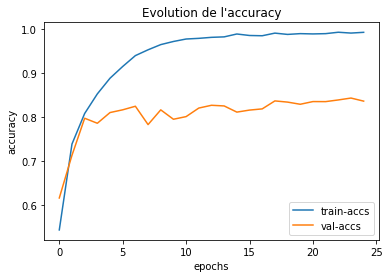

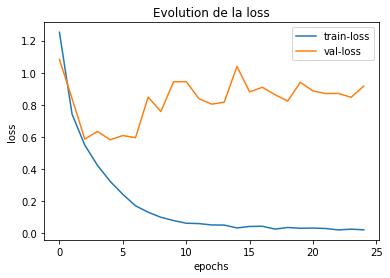

In [15]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.legend(["train-accs", "val-accs"])
plt.title("Evolution de l'accuracy")
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend(["train-loss", "val-loss"])
plt.title("Evolution de la loss")
plt.show()

#### Question 3.5
Visualisation de quelques filtres de la première et de la dernière couche de convolution du modèle

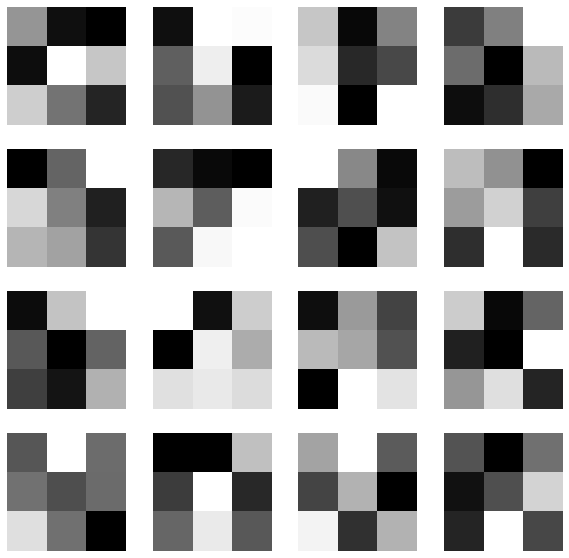

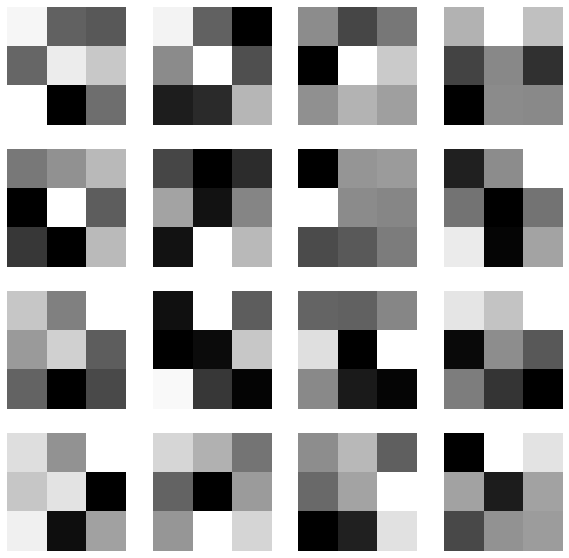

In [12]:
def display_filters(filters, num_filters=16, figsize=(10, 10)):
    """
        filters: numpy array
        Un tableau Numpy de filtres de convolution.
        num_filters: int, default 16
        Nombre de filtres à afficher.
        figsize: tuple, default (10, 10)
        Taille de la figure.
    """
    fig, axes = plt.subplots(4, 4, figsize=figsize)
    for i in range(num_filters):
        axes[i // 4, i % 4].imshow(filters[i, 0, :, :], cmap='gray')
        axes[i // 4, i % 4].axis('off')
    plt.show()

model = ResNet18(activation_str=activation_str,initialization=initialization).to(device)

display_filters(model.get_first_conv_layer_filters())
display_filters(model.get_last_conv_layer_filters())

#### Question 3.6
Visualisation de quelques features map de la première et de la dernière couche de convolution du modèle

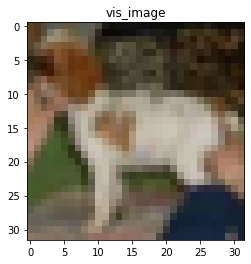

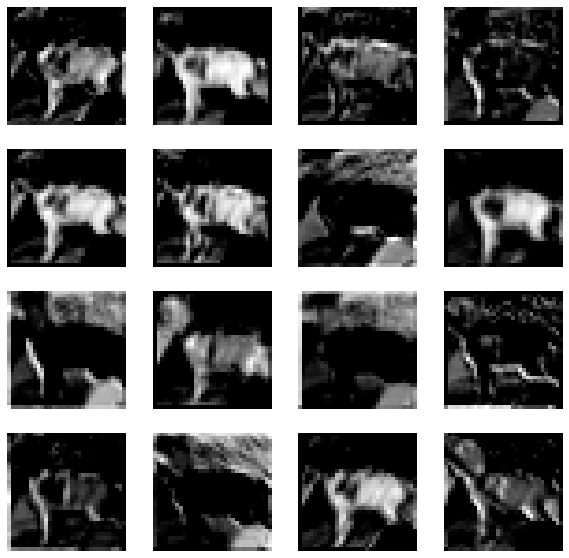

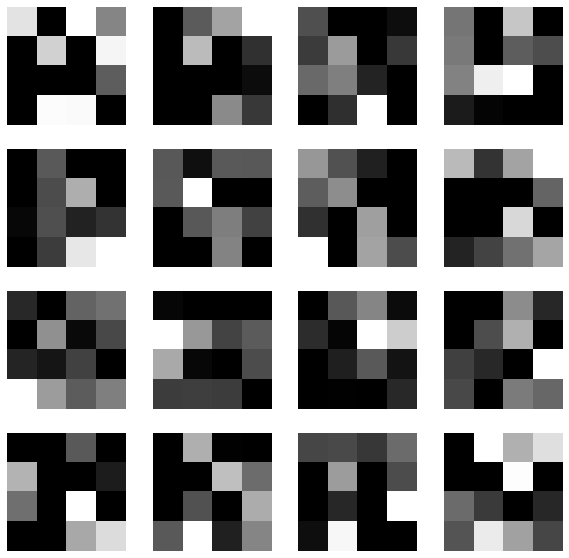

In [14]:
def display_features_map(features_map, num_filters=16, figsize=(10, 10)):
    """
        features_map: numpy array
        Un tableau Numpy de la carte de caractéristiques.
        num_filters: int, default 16
        Nombre de filtres à afficher.
        figsize: tuple, default (10, 10)
        Taille de la figure.
    """
    fig, axes = plt.subplots(4, 4, figsize=figsize)
    for i in range(num_filters):
        axes[i // 4, i % 4].imshow(features_map[0, i, :, :], cmap='gray')
        axes[i // 4, i % 4].axis('off')
    plt.show()

import pickle
vis_image = pickle.load(open("vis_image.pkl", "rb")).to(device)
plt.imshow(vis_image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
plt.title("vis_image")
plt.show()

input = vis_image.to(device)
input = model.activation(model.bn1(model.conv1(input)))
display_features_map(input.cpu().detach().numpy())
input = model.layer1(input)
input = model.layer2(input)
input = model.layer3(input)
input = model.layer4(input)
display_features_map(input.cpu().detach().numpy())

#### Question 3.7
Grid search pour optimiser les hyperparamètres

In [19]:
import pandas as pd
from tqdm import tqdm

activation_functions = ['relu' , 'tanh']
initialization_functions = ['xavier_normal', 'xavier_uniform', 'kaiming_normal']

df_acc = pd.DataFrame(index=initialization_functions, columns = activation_functions)
df_loss = pd.DataFrame(index=initialization_functions, columns = activation_functions)

n_epochs = 25
train_loader, val_loader = get_cifar10()

total_accs = {'relu_xavier_normal' : [], 'relu_xavier_uniform' : [], 'relu_kaiming_normal' : [], 'tanh_xavier_normal' : [], 'tanh_xavier_uniform' : [], 'tanh_kaiming_normal' : []}
total_loss = {'relu_xavier_normal' : [], 'relu_xavier_uniform' : [], 'relu_kaiming_normal' : [], 'tanh_xavier_normal' : [], 'tanh_xavier_uniform' : [], 'tanh_kaiming_normal' : []}

for activation in activation_functions:
    for initialization in initialization_functions:
        print("activation: ", activation, "initialization: ", initialization)
        model = ResNet18(activation_str=activation,initialization=initialization).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())
        for epoch in tqdm(range(n_epochs)):
            train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
            val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
            total_accs[activation+'_'+initialization].append(val_acc)
            total_loss[activation+'_'+initialization].append(val_loss)
        print("last val_acc: ", val_acc, "last val_loss: ", val_loss)
        df_acc.loc[initialization, activation] = val_acc
        df_loss.loc[initialization, activation] = val_loss

print(df_acc)
print(df_loss)
print(total_accs)
print(total_loss)

df_acc.to_csv('./df_acc.csv')
df_loss.to_csv('./df_loss.csv')

Files already downloaded and verified
Files already downloaded and verified
activation:  relu initialization:  xavier_normal


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.537680 | Train Loss: 1.275094


  4%|▍         | 1/25 [01:04<25:50, 64.60s/it]

Epoch: 0 | Val Acc: 0.607200   | Val Loss: 1.126641
Epoch: 1 | Train Acc: 0.733820 | Train Loss: 0.754028


  8%|▊         | 2/25 [02:08<24:39, 64.33s/it]

Epoch: 1 | Val Acc: 0.659000   | Val Loss: 1.044067
Epoch: 2 | Train Acc: 0.806660 | Train Loss: 0.552486


 12%|█▏        | 3/25 [03:12<23:31, 64.18s/it]

Epoch: 2 | Val Acc: 0.717300   | Val Loss: 0.852561
Epoch: 3 | Train Acc: 0.853660 | Train Loss: 0.420385


 16%|█▌        | 4/25 [04:16<22:27, 64.14s/it]

Epoch: 3 | Val Acc: 0.814700   | Val Loss: 0.558538
Epoch: 4 | Train Acc: 0.889260 | Train Loss: 0.319873


 20%|██        | 5/25 [05:20<21:21, 64.09s/it]

Epoch: 4 | Val Acc: 0.802400   | Val Loss: 0.623721
Epoch: 5 | Train Acc: 0.914820 | Train Loss: 0.241300


 24%|██▍       | 6/25 [06:24<20:16, 64.05s/it]

Epoch: 5 | Val Acc: 0.799900   | Val Loss: 0.653019
Epoch: 6 | Train Acc: 0.940500 | Train Loss: 0.170131


 28%|██▊       | 7/25 [07:28<19:12, 64.05s/it]

Epoch: 6 | Val Acc: 0.814800   | Val Loss: 0.640741
Epoch: 7 | Train Acc: 0.954600 | Train Loss: 0.128122


 32%|███▏      | 8/25 [08:32<18:08, 64.02s/it]

Epoch: 7 | Val Acc: 0.823900   | Val Loss: 0.656486
Epoch: 8 | Train Acc: 0.966540 | Train Loss: 0.094556


 36%|███▌      | 9/25 [09:36<17:04, 64.02s/it]

Epoch: 8 | Val Acc: 0.790300   | Val Loss: 0.923201
Epoch: 9 | Train Acc: 0.973240 | Train Loss: 0.076256


 40%|████      | 10/25 [10:40<16:00, 64.02s/it]

Epoch: 9 | Val Acc: 0.826100   | Val Loss: 0.777638
Epoch: 10 | Train Acc: 0.976940 | Train Loss: 0.066673


 44%|████▍     | 11/25 [11:44<14:56, 64.02s/it]

Epoch: 10 | Val Acc: 0.832100   | Val Loss: 0.705297
Epoch: 11 | Train Acc: 0.981920 | Train Loss: 0.052600


 48%|████▊     | 12/25 [12:48<13:52, 64.00s/it]

Epoch: 11 | Val Acc: 0.822600   | Val Loss: 0.798364
Epoch: 12 | Train Acc: 0.983380 | Train Loss: 0.048085


 52%|█████▏    | 13/25 [13:52<12:48, 64.00s/it]

Epoch: 12 | Val Acc: 0.839500   | Val Loss: 0.750100
Epoch: 13 | Train Acc: 0.982160 | Train Loss: 0.050525


 56%|█████▌    | 14/25 [14:56<11:43, 63.99s/it]

Epoch: 13 | Val Acc: 0.837800   | Val Loss: 0.716529
Epoch: 14 | Train Acc: 0.984980 | Train Loss: 0.043592


 60%|██████    | 15/25 [16:00<10:40, 64.00s/it]

Epoch: 14 | Val Acc: 0.831700   | Val Loss: 0.760553
Epoch: 15 | Train Acc: 0.984880 | Train Loss: 0.042179


 64%|██████▍   | 16/25 [17:04<09:36, 64.02s/it]

Epoch: 15 | Val Acc: 0.829100   | Val Loss: 0.813554
Epoch: 16 | Train Acc: 0.987520 | Train Loss: 0.037091


 68%|██████▊   | 17/25 [18:08<08:32, 64.00s/it]

Epoch: 16 | Val Acc: 0.816100   | Val Loss: 0.962961
Epoch: 17 | Train Acc: 0.988800 | Train Loss: 0.032132


 72%|███████▏  | 18/25 [19:12<07:28, 64.05s/it]

Epoch: 17 | Val Acc: 0.833800   | Val Loss: 0.827801
Epoch: 18 | Train Acc: 0.985860 | Train Loss: 0.041076


 76%|███████▌  | 19/25 [20:16<06:24, 64.02s/it]

Epoch: 18 | Val Acc: 0.839300   | Val Loss: 0.795285
Epoch: 19 | Train Acc: 0.990800 | Train Loss: 0.027327


 80%|████████  | 20/25 [21:20<05:19, 64.00s/it]

Epoch: 19 | Val Acc: 0.822400   | Val Loss: 0.961087
Epoch: 20 | Train Acc: 0.988180 | Train Loss: 0.033296


 84%|████████▍ | 21/25 [22:24<04:15, 63.99s/it]

Epoch: 20 | Val Acc: 0.845200   | Val Loss: 0.807452
Epoch: 21 | Train Acc: 0.990200 | Train Loss: 0.027393


 88%|████████▊ | 22/25 [23:28<03:11, 63.99s/it]

Epoch: 21 | Val Acc: 0.845700   | Val Loss: 0.790685
Epoch: 22 | Train Acc: 0.991260 | Train Loss: 0.025093


 92%|█████████▏| 23/25 [24:32<02:07, 63.99s/it]

Epoch: 22 | Val Acc: 0.842600   | Val Loss: 0.804990
Epoch: 23 | Train Acc: 0.991800 | Train Loss: 0.025688


 96%|█████████▌| 24/25 [25:36<01:03, 63.97s/it]

Epoch: 23 | Val Acc: 0.823300   | Val Loss: 0.990397
Epoch: 24 | Train Acc: 0.991060 | Train Loss: 0.026122


100%|██████████| 25/25 [26:40<00:00, 64.02s/it]


Epoch: 24 | Val Acc: 0.813800   | Val Loss: 1.037863
last val_acc:  0.8138 last val_loss:  1.0378625543811653
activation:  relu initialization:  xavier_uniform


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.542380 | Train Loss: 1.259786


  4%|▍         | 1/25 [01:04<25:37, 64.08s/it]

Epoch: 0 | Val Acc: 0.579600   | Val Loss: 1.210835
Epoch: 1 | Train Acc: 0.729260 | Train Loss: 0.763673


  8%|▊         | 2/25 [02:08<24:34, 64.12s/it]

Epoch: 1 | Val Acc: 0.734200   | Val Loss: 0.776342
Epoch: 2 | Train Acc: 0.803720 | Train Loss: 0.561301


 12%|█▏        | 3/25 [03:12<23:30, 64.12s/it]

Epoch: 2 | Val Acc: 0.786900   | Val Loss: 0.621784
Epoch: 3 | Train Acc: 0.847160 | Train Loss: 0.439663


 16%|█▌        | 4/25 [04:16<22:26, 64.13s/it]

Epoch: 3 | Val Acc: 0.780900   | Val Loss: 0.663116
Epoch: 4 | Train Acc: 0.883320 | Train Loss: 0.334880


 20%|██        | 5/25 [05:20<21:22, 64.11s/it]

Epoch: 4 | Val Acc: 0.804600   | Val Loss: 0.632647
Epoch: 5 | Train Acc: 0.910600 | Train Loss: 0.255566


 24%|██▍       | 6/25 [06:24<20:18, 64.11s/it]

Epoch: 5 | Val Acc: 0.807300   | Val Loss: 0.641731
Epoch: 6 | Train Acc: 0.936080 | Train Loss: 0.182709


 28%|██▊       | 7/25 [07:28<19:14, 64.12s/it]

Epoch: 6 | Val Acc: 0.792100   | Val Loss: 0.731070
Epoch: 7 | Train Acc: 0.952780 | Train Loss: 0.133570


 32%|███▏      | 8/25 [08:32<18:09, 64.09s/it]

Epoch: 7 | Val Acc: 0.829200   | Val Loss: 0.617386
Epoch: 8 | Train Acc: 0.964180 | Train Loss: 0.103415


 36%|███▌      | 9/25 [09:36<17:05, 64.09s/it]

Epoch: 8 | Val Acc: 0.823800   | Val Loss: 0.706572
Epoch: 9 | Train Acc: 0.971880 | Train Loss: 0.078698


 40%|████      | 10/25 [10:41<16:01, 64.10s/it]

Epoch: 9 | Val Acc: 0.821800   | Val Loss: 0.749762
Epoch: 10 | Train Acc: 0.977160 | Train Loss: 0.066770


 44%|████▍     | 11/25 [11:45<14:56, 64.05s/it]

Epoch: 10 | Val Acc: 0.822300   | Val Loss: 0.759975
Epoch: 11 | Train Acc: 0.979920 | Train Loss: 0.059334


 48%|████▊     | 12/25 [12:48<13:52, 64.02s/it]

Epoch: 11 | Val Acc: 0.808800   | Val Loss: 0.868905
Epoch: 12 | Train Acc: 0.980860 | Train Loss: 0.054978


 52%|█████▏    | 13/25 [13:52<12:47, 64.00s/it]

Epoch: 12 | Val Acc: 0.818400   | Val Loss: 0.861258
Epoch: 13 | Train Acc: 0.985180 | Train Loss: 0.043873


 56%|█████▌    | 14/25 [14:56<11:43, 63.98s/it]

Epoch: 13 | Val Acc: 0.841900   | Val Loss: 0.737361
Epoch: 14 | Train Acc: 0.984260 | Train Loss: 0.045443


 60%|██████    | 15/25 [16:00<10:39, 63.99s/it]

Epoch: 14 | Val Acc: 0.809000   | Val Loss: 0.995100
Epoch: 15 | Train Acc: 0.985320 | Train Loss: 0.042920


 64%|██████▍   | 16/25 [17:04<09:35, 64.00s/it]

Epoch: 15 | Val Acc: 0.840200   | Val Loss: 0.747321
Epoch: 16 | Train Acc: 0.988460 | Train Loss: 0.034037


 68%|██████▊   | 17/25 [18:08<08:31, 64.00s/it]

Epoch: 16 | Val Acc: 0.817000   | Val Loss: 0.969734
Epoch: 17 | Train Acc: 0.985380 | Train Loss: 0.042650


 72%|███████▏  | 18/25 [19:12<07:28, 64.02s/it]

Epoch: 17 | Val Acc: 0.838400   | Val Loss: 0.802780
Epoch: 18 | Train Acc: 0.989000 | Train Loss: 0.031142


 76%|███████▌  | 19/25 [20:16<06:23, 63.99s/it]

Epoch: 18 | Val Acc: 0.837700   | Val Loss: 0.840105
Epoch: 19 | Train Acc: 0.988560 | Train Loss: 0.032162


 80%|████████  | 20/25 [21:20<05:19, 63.96s/it]

Epoch: 19 | Val Acc: 0.830400   | Val Loss: 0.887987
Epoch: 20 | Train Acc: 0.989940 | Train Loss: 0.028652


 84%|████████▍ | 21/25 [22:24<04:15, 63.94s/it]

Epoch: 20 | Val Acc: 0.834600   | Val Loss: 0.857166
Epoch: 21 | Train Acc: 0.990160 | Train Loss: 0.028780


 88%|████████▊ | 22/25 [23:28<03:11, 63.91s/it]

Epoch: 21 | Val Acc: 0.835600   | Val Loss: 0.881079
Epoch: 22 | Train Acc: 0.987860 | Train Loss: 0.035078


 92%|█████████▏| 23/25 [24:32<02:07, 63.89s/it]

Epoch: 22 | Val Acc: 0.842200   | Val Loss: 0.827417
Epoch: 23 | Train Acc: 0.990900 | Train Loss: 0.025238


 96%|█████████▌| 24/25 [25:36<01:03, 63.88s/it]

Epoch: 23 | Val Acc: 0.843600   | Val Loss: 0.833102
Epoch: 24 | Train Acc: 0.991680 | Train Loss: 0.024088


100%|██████████| 25/25 [26:40<00:00, 64.00s/it]


Epoch: 24 | Val Acc: 0.835500   | Val Loss: 0.864122
last val_acc:  0.8355 last val_loss:  0.8641215140306497
activation:  relu initialization:  kaiming_normal


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.544500 | Train Loss: 1.248388


  4%|▍         | 1/25 [01:04<25:40, 64.20s/it]

Epoch: 0 | Val Acc: 0.580700   | Val Loss: 1.273040
Epoch: 1 | Train Acc: 0.740000 | Train Loss: 0.738141


  8%|▊         | 2/25 [02:08<24:35, 64.14s/it]

Epoch: 1 | Val Acc: 0.729300   | Val Loss: 0.778978
Epoch: 2 | Train Acc: 0.808900 | Train Loss: 0.541954


 12%|█▏        | 3/25 [03:12<23:30, 64.12s/it]

Epoch: 2 | Val Acc: 0.797800   | Val Loss: 0.594597
Epoch: 3 | Train Acc: 0.855680 | Train Loss: 0.410296


 16%|█▌        | 4/25 [04:16<22:25, 64.07s/it]

Epoch: 3 | Val Acc: 0.794700   | Val Loss: 0.618895
Epoch: 4 | Train Acc: 0.894280 | Train Loss: 0.306140


 20%|██        | 5/25 [05:20<21:20, 64.03s/it]

Epoch: 4 | Val Acc: 0.745000   | Val Loss: 0.872584
Epoch: 5 | Train Acc: 0.922780 | Train Loss: 0.219272


 24%|██▍       | 6/25 [06:24<20:16, 64.02s/it]

Epoch: 5 | Val Acc: 0.793400   | Val Loss: 0.690282
Epoch: 6 | Train Acc: 0.943500 | Train Loss: 0.157690


 28%|██▊       | 7/25 [07:28<19:11, 63.99s/it]

Epoch: 6 | Val Acc: 0.810400   | Val Loss: 0.675792
Epoch: 7 | Train Acc: 0.960980 | Train Loss: 0.110407


 32%|███▏      | 8/25 [08:32<18:08, 64.02s/it]

Epoch: 7 | Val Acc: 0.828200   | Val Loss: 0.638955
Epoch: 8 | Train Acc: 0.968440 | Train Loss: 0.088502


 36%|███▌      | 9/25 [09:36<17:03, 63.99s/it]

Epoch: 8 | Val Acc: 0.821800   | Val Loss: 0.735999
Epoch: 9 | Train Acc: 0.975820 | Train Loss: 0.070656


 40%|████      | 10/25 [10:40<15:59, 63.97s/it]

Epoch: 9 | Val Acc: 0.822300   | Val Loss: 0.746874
Epoch: 10 | Train Acc: 0.978020 | Train Loss: 0.062337


 44%|████▍     | 11/25 [11:44<14:55, 63.96s/it]

Epoch: 10 | Val Acc: 0.842900   | Val Loss: 0.701142
Epoch: 11 | Train Acc: 0.980660 | Train Loss: 0.054291


 48%|████▊     | 12/25 [12:48<13:51, 63.93s/it]

Epoch: 11 | Val Acc: 0.828600   | Val Loss: 0.795386
Epoch: 12 | Train Acc: 0.982720 | Train Loss: 0.049737


 52%|█████▏    | 13/25 [13:52<12:47, 63.95s/it]

Epoch: 12 | Val Acc: 0.811100   | Val Loss: 0.931602
Epoch: 13 | Train Acc: 0.981660 | Train Loss: 0.051937


 56%|█████▌    | 14/25 [14:55<11:43, 63.91s/it]

Epoch: 13 | Val Acc: 0.818600   | Val Loss: 0.891096
Epoch: 14 | Train Acc: 0.985240 | Train Loss: 0.043507


 60%|██████    | 15/25 [15:59<10:38, 63.88s/it]

Epoch: 14 | Val Acc: 0.836800   | Val Loss: 0.810638
Epoch: 15 | Train Acc: 0.987860 | Train Loss: 0.034521


 64%|██████▍   | 16/25 [17:03<09:34, 63.87s/it]

Epoch: 15 | Val Acc: 0.825600   | Val Loss: 0.908464
Epoch: 16 | Train Acc: 0.988300 | Train Loss: 0.034267


 68%|██████▊   | 17/25 [18:07<08:31, 63.88s/it]

Epoch: 16 | Val Acc: 0.824300   | Val Loss: 0.901226
Epoch: 17 | Train Acc: 0.984900 | Train Loss: 0.042630


 72%|███████▏  | 18/25 [19:11<07:27, 63.93s/it]

Epoch: 17 | Val Acc: 0.834300   | Val Loss: 0.807747
Epoch: 18 | Train Acc: 0.988260 | Train Loss: 0.033152


 76%|███████▌  | 19/25 [20:15<06:23, 63.86s/it]

Epoch: 18 | Val Acc: 0.824300   | Val Loss: 0.913753
Epoch: 19 | Train Acc: 0.989600 | Train Loss: 0.029853


 80%|████████  | 20/25 [21:18<05:18, 63.80s/it]

Epoch: 19 | Val Acc: 0.835000   | Val Loss: 0.861128
Epoch: 20 | Train Acc: 0.990580 | Train Loss: 0.027112


 84%|████████▍ | 21/25 [22:22<04:15, 63.84s/it]

Epoch: 20 | Val Acc: 0.827600   | Val Loss: 0.940996
Epoch: 21 | Train Acc: 0.987820 | Train Loss: 0.034354


 88%|████████▊ | 22/25 [23:26<03:11, 63.86s/it]

Epoch: 21 | Val Acc: 0.839300   | Val Loss: 0.853998
Epoch: 22 | Train Acc: 0.992840 | Train Loss: 0.021005


 92%|█████████▏| 23/25 [24:30<02:07, 63.90s/it]

Epoch: 22 | Val Acc: 0.837400   | Val Loss: 0.885504
Epoch: 23 | Train Acc: 0.989440 | Train Loss: 0.031193


 96%|█████████▌| 24/25 [25:34<01:03, 63.86s/it]

Epoch: 23 | Val Acc: 0.831100   | Val Loss: 0.945978
Epoch: 24 | Train Acc: 0.991380 | Train Loss: 0.025668


100%|██████████| 25/25 [26:38<00:00, 63.93s/it]


Epoch: 24 | Val Acc: 0.832900   | Val Loss: 0.915121
last val_acc:  0.8329 last val_loss:  0.9151209781441507
activation:  tanh initialization:  xavier_normal


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.392640 | Train Loss: 1.662930


  4%|▍         | 1/25 [01:04<25:59, 64.98s/it]

Epoch: 0 | Val Acc: 0.453200   | Val Loss: 1.538969
Epoch: 1 | Train Acc: 0.545180 | Train Loss: 1.251809


  8%|▊         | 2/25 [02:09<24:55, 65.00s/it]

Epoch: 1 | Val Acc: 0.575100   | Val Loss: 1.168163
Epoch: 2 | Train Acc: 0.646480 | Train Loss: 0.987858


 12%|█▏        | 3/25 [03:15<23:50, 65.02s/it]

Epoch: 2 | Val Acc: 0.618000   | Val Loss: 1.061321
Epoch: 3 | Train Acc: 0.702740 | Train Loss: 0.829908


 16%|█▌        | 4/25 [04:19<22:43, 64.94s/it]

Epoch: 3 | Val Acc: 0.702400   | Val Loss: 0.845476
Epoch: 4 | Train Acc: 0.747040 | Train Loss: 0.709452


 20%|██        | 5/25 [05:24<21:38, 64.90s/it]

Epoch: 4 | Val Acc: 0.726800   | Val Loss: 0.784856
Epoch: 5 | Train Acc: 0.785180 | Train Loss: 0.605702


 24%|██▍       | 6/25 [06:29<20:33, 64.94s/it]

Epoch: 5 | Val Acc: 0.716500   | Val Loss: 0.828075
Epoch: 6 | Train Acc: 0.821420 | Train Loss: 0.504073


 28%|██▊       | 7/25 [07:34<19:29, 64.96s/it]

Epoch: 6 | Val Acc: 0.718400   | Val Loss: 0.872781
Epoch: 7 | Train Acc: 0.852580 | Train Loss: 0.414350


 32%|███▏      | 8/25 [08:39<18:24, 64.99s/it]

Epoch: 7 | Val Acc: 0.753400   | Val Loss: 0.778502
Epoch: 8 | Train Acc: 0.884360 | Train Loss: 0.327124


 36%|███▌      | 9/25 [09:44<17:19, 64.99s/it]

Epoch: 8 | Val Acc: 0.735000   | Val Loss: 0.887592
Epoch: 9 | Train Acc: 0.910920 | Train Loss: 0.251375


 40%|████      | 10/25 [10:49<16:14, 64.97s/it]

Epoch: 9 | Val Acc: 0.751000   | Val Loss: 0.840414
Epoch: 10 | Train Acc: 0.931000 | Train Loss: 0.196160


 44%|████▍     | 11/25 [11:54<15:09, 65.00s/it]

Epoch: 10 | Val Acc: 0.747200   | Val Loss: 0.879952
Epoch: 11 | Train Acc: 0.949640 | Train Loss: 0.143296


 48%|████▊     | 12/25 [12:59<14:04, 64.99s/it]

Epoch: 11 | Val Acc: 0.744300   | Val Loss: 0.985035
Epoch: 12 | Train Acc: 0.963760 | Train Loss: 0.105816


 52%|█████▏    | 13/25 [14:04<13:00, 65.01s/it]

Epoch: 12 | Val Acc: 0.744800   | Val Loss: 1.095299
Epoch: 13 | Train Acc: 0.962800 | Train Loss: 0.104127


 56%|█████▌    | 14/25 [15:09<11:55, 65.02s/it]

Epoch: 13 | Val Acc: 0.746600   | Val Loss: 1.152033
Epoch: 14 | Train Acc: 0.970400 | Train Loss: 0.082474


 60%|██████    | 15/25 [16:14<10:50, 65.06s/it]

Epoch: 14 | Val Acc: 0.735800   | Val Loss: 1.227432
Epoch: 15 | Train Acc: 0.972600 | Train Loss: 0.078012


 64%|██████▍   | 16/25 [17:19<09:45, 65.04s/it]

Epoch: 15 | Val Acc: 0.742800   | Val Loss: 1.248508
Epoch: 16 | Train Acc: 0.977000 | Train Loss: 0.065608


 68%|██████▊   | 17/25 [18:24<08:40, 65.03s/it]

Epoch: 16 | Val Acc: 0.752300   | Val Loss: 1.209274
Epoch: 17 | Train Acc: 0.976700 | Train Loss: 0.067992


 72%|███████▏  | 18/25 [19:30<07:35, 65.06s/it]

Epoch: 17 | Val Acc: 0.750500   | Val Loss: 1.211265
Epoch: 18 | Train Acc: 0.980920 | Train Loss: 0.054410


 76%|███████▌  | 19/25 [20:35<06:30, 65.07s/it]

Epoch: 18 | Val Acc: 0.738200   | Val Loss: 1.368123
Epoch: 19 | Train Acc: 0.978360 | Train Loss: 0.060463


 80%|████████  | 20/25 [21:40<05:25, 65.08s/it]

Epoch: 19 | Val Acc: 0.758300   | Val Loss: 1.231461
Epoch: 20 | Train Acc: 0.981500 | Train Loss: 0.052796


 84%|████████▍ | 21/25 [22:45<04:20, 65.05s/it]

Epoch: 20 | Val Acc: 0.748400   | Val Loss: 1.296115
Epoch: 21 | Train Acc: 0.981860 | Train Loss: 0.051981


 88%|████████▊ | 22/25 [23:50<03:15, 65.07s/it]

Epoch: 21 | Val Acc: 0.758400   | Val Loss: 1.251512
Epoch: 22 | Train Acc: 0.982480 | Train Loss: 0.050438


 92%|█████████▏| 23/25 [24:55<02:10, 65.05s/it]

Epoch: 22 | Val Acc: 0.765300   | Val Loss: 1.221365
Epoch: 23 | Train Acc: 0.985560 | Train Loss: 0.040640


 96%|█████████▌| 24/25 [26:00<01:05, 65.02s/it]

Epoch: 23 | Val Acc: 0.740300   | Val Loss: 1.489651
Epoch: 24 | Train Acc: 0.984500 | Train Loss: 0.045234


100%|██████████| 25/25 [27:05<00:00, 65.02s/it]


Epoch: 24 | Val Acc: 0.755800   | Val Loss: 1.339511
last val_acc:  0.7558 last val_loss:  1.3395114669316932
activation:  tanh initialization:  xavier_uniform


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.395540 | Train Loss: 1.660213


  4%|▍         | 1/25 [01:04<25:57, 64.91s/it]

Epoch: 0 | Val Acc: 0.437200   | Val Loss: 1.556292
Epoch: 1 | Train Acc: 0.564700 | Train Loss: 1.205505


  8%|▊         | 2/25 [02:09<24:53, 64.94s/it]

Epoch: 1 | Val Acc: 0.583600   | Val Loss: 1.157994
Epoch: 2 | Train Acc: 0.656220 | Train Loss: 0.961889


 12%|█▏        | 3/25 [03:14<23:49, 64.96s/it]

Epoch: 2 | Val Acc: 0.623200   | Val Loss: 1.062431
Epoch: 3 | Train Acc: 0.711500 | Train Loss: 0.810560


 16%|█▌        | 4/25 [04:19<22:44, 64.97s/it]

Epoch: 3 | Val Acc: 0.691600   | Val Loss: 0.877946
Epoch: 4 | Train Acc: 0.753880 | Train Loss: 0.694858


 20%|██        | 5/25 [05:24<21:39, 64.99s/it]

Epoch: 4 | Val Acc: 0.687200   | Val Loss: 0.874617
Epoch: 5 | Train Acc: 0.789660 | Train Loss: 0.593881


 24%|██▍       | 6/25 [06:30<20:36, 65.06s/it]

Epoch: 5 | Val Acc: 0.743200   | Val Loss: 0.750909
Epoch: 6 | Train Acc: 0.823000 | Train Loss: 0.500539


 28%|██▊       | 7/25 [07:34<19:29, 64.99s/it]

Epoch: 6 | Val Acc: 0.751600   | Val Loss: 0.714676
Epoch: 7 | Train Acc: 0.855560 | Train Loss: 0.407295


 32%|███▏      | 8/25 [08:39<18:24, 64.96s/it]

Epoch: 7 | Val Acc: 0.683200   | Val Loss: 1.042238
Epoch: 8 | Train Acc: 0.884900 | Train Loss: 0.326067


 36%|███▌      | 9/25 [09:44<17:20, 65.03s/it]

Epoch: 8 | Val Acc: 0.741700   | Val Loss: 0.837797
Epoch: 9 | Train Acc: 0.913020 | Train Loss: 0.246863


 40%|████      | 10/25 [10:50<16:15, 65.03s/it]

Epoch: 9 | Val Acc: 0.735300   | Val Loss: 0.920745
Epoch: 10 | Train Acc: 0.929720 | Train Loss: 0.193960


 44%|████▍     | 11/25 [11:54<15:10, 65.01s/it]

Epoch: 10 | Val Acc: 0.755300   | Val Loss: 0.890428
Epoch: 11 | Train Acc: 0.949580 | Train Loss: 0.142469


 48%|████▊     | 12/25 [13:00<14:05, 65.04s/it]

Epoch: 11 | Val Acc: 0.734200   | Val Loss: 1.078853
Epoch: 12 | Train Acc: 0.959560 | Train Loss: 0.115446


 52%|█████▏    | 13/25 [14:05<13:00, 65.05s/it]

Epoch: 12 | Val Acc: 0.744500   | Val Loss: 1.023339
Epoch: 13 | Train Acc: 0.962980 | Train Loss: 0.104039


 56%|█████▌    | 14/25 [15:10<11:55, 65.02s/it]

Epoch: 13 | Val Acc: 0.728800   | Val Loss: 1.193833
Epoch: 14 | Train Acc: 0.970200 | Train Loss: 0.082578


 60%|██████    | 15/25 [16:15<10:50, 65.03s/it]

Epoch: 14 | Val Acc: 0.751600   | Val Loss: 1.122774
Epoch: 15 | Train Acc: 0.973360 | Train Loss: 0.076611


 64%|██████▍   | 16/25 [17:20<09:45, 65.05s/it]

Epoch: 15 | Val Acc: 0.764100   | Val Loss: 1.105451
Epoch: 16 | Train Acc: 0.974640 | Train Loss: 0.074019


 68%|██████▊   | 17/25 [18:25<08:40, 65.05s/it]

Epoch: 16 | Val Acc: 0.753000   | Val Loss: 1.105834
Epoch: 17 | Train Acc: 0.977020 | Train Loss: 0.066105


 72%|███████▏  | 18/25 [19:30<07:35, 65.07s/it]

Epoch: 17 | Val Acc: 0.764700   | Val Loss: 1.117202
Epoch: 18 | Train Acc: 0.981260 | Train Loss: 0.055765


 76%|███████▌  | 19/25 [20:35<06:30, 65.06s/it]

Epoch: 18 | Val Acc: 0.767100   | Val Loss: 1.157990
Epoch: 19 | Train Acc: 0.981000 | Train Loss: 0.054679


 80%|████████  | 20/25 [21:40<05:25, 65.08s/it]

Epoch: 19 | Val Acc: 0.752400   | Val Loss: 1.248245
Epoch: 20 | Train Acc: 0.980820 | Train Loss: 0.054309


 84%|████████▍ | 21/25 [22:45<04:20, 65.08s/it]

Epoch: 20 | Val Acc: 0.737800   | Val Loss: 1.433721
Epoch: 21 | Train Acc: 0.982560 | Train Loss: 0.050966


 88%|████████▊ | 22/25 [23:50<03:15, 65.07s/it]

Epoch: 21 | Val Acc: 0.747600   | Val Loss: 1.316527
Epoch: 22 | Train Acc: 0.986600 | Train Loss: 0.040458


 92%|█████████▏| 23/25 [24:55<02:10, 65.05s/it]

Epoch: 22 | Val Acc: 0.722200   | Val Loss: 1.626670
Epoch: 23 | Train Acc: 0.983420 | Train Loss: 0.048208


 96%|█████████▌| 24/25 [26:00<01:05, 65.08s/it]

Epoch: 23 | Val Acc: 0.726600   | Val Loss: 1.575434
Epoch: 24 | Train Acc: 0.984420 | Train Loss: 0.042695


100%|██████████| 25/25 [27:05<00:00, 65.04s/it]


Epoch: 24 | Val Acc: 0.738300   | Val Loss: 1.478897
last val_acc:  0.7383 last val_loss:  1.4788974568813662
activation:  tanh initialization:  kaiming_normal


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Acc: 0.410540 | Train Loss: 1.623645


  4%|▍         | 1/25 [01:05<26:04, 65.21s/it]

Epoch: 0 | Val Acc: 0.453000   | Val Loss: 1.500663
Epoch: 1 | Train Acc: 0.584140 | Train Loss: 1.153365


  8%|▊         | 2/25 [02:10<24:56, 65.07s/it]

Epoch: 1 | Val Acc: 0.605700   | Val Loss: 1.069676
Epoch: 2 | Train Acc: 0.668300 | Train Loss: 0.921003


 12%|█▏        | 3/25 [03:15<23:50, 65.04s/it]

Epoch: 2 | Val Acc: 0.658800   | Val Loss: 0.939672
Epoch: 3 | Train Acc: 0.726620 | Train Loss: 0.769170


 16%|█▌        | 4/25 [04:20<22:46, 65.09s/it]

Epoch: 3 | Val Acc: 0.706600   | Val Loss: 0.818209
Epoch: 4 | Train Acc: 0.768740 | Train Loss: 0.651794


 20%|██        | 5/25 [05:25<21:41, 65.07s/it]

Epoch: 4 | Val Acc: 0.720000   | Val Loss: 0.805150
Epoch: 5 | Train Acc: 0.805900 | Train Loss: 0.550888


 24%|██▍       | 6/25 [06:30<20:36, 65.08s/it]

Epoch: 5 | Val Acc: 0.711700   | Val Loss: 0.842476
Epoch: 6 | Train Acc: 0.842520 | Train Loss: 0.447004


 28%|██▊       | 7/25 [07:35<19:31, 65.06s/it]

Epoch: 6 | Val Acc: 0.730900   | Val Loss: 0.787403
Epoch: 7 | Train Acc: 0.871340 | Train Loss: 0.360801


 32%|███▏      | 8/25 [08:40<18:26, 65.06s/it]

Epoch: 7 | Val Acc: 0.737500   | Val Loss: 0.848447
Epoch: 8 | Train Acc: 0.904020 | Train Loss: 0.269060


 36%|███▌      | 9/25 [09:45<17:20, 65.03s/it]

Epoch: 8 | Val Acc: 0.749800   | Val Loss: 0.842891
Epoch: 9 | Train Acc: 0.927240 | Train Loss: 0.202809


 40%|████      | 10/25 [10:50<16:15, 65.06s/it]

Epoch: 9 | Val Acc: 0.719900   | Val Loss: 1.100598
Epoch: 10 | Train Acc: 0.945660 | Train Loss: 0.152689


 44%|████▍     | 11/25 [11:55<15:10, 65.04s/it]

Epoch: 10 | Val Acc: 0.739700   | Val Loss: 1.031246
Epoch: 11 | Train Acc: 0.960320 | Train Loss: 0.114668


 48%|████▊     | 12/25 [13:00<14:06, 65.12s/it]

Epoch: 11 | Val Acc: 0.756700   | Val Loss: 1.030050
Epoch: 12 | Train Acc: 0.964140 | Train Loss: 0.102907


 52%|█████▏    | 13/25 [14:06<13:01, 65.11s/it]

Epoch: 12 | Val Acc: 0.749700   | Val Loss: 1.077100
Epoch: 13 | Train Acc: 0.968500 | Train Loss: 0.089890


 56%|█████▌    | 14/25 [15:11<11:55, 65.07s/it]

Epoch: 13 | Val Acc: 0.749000   | Val Loss: 1.155406
Epoch: 14 | Train Acc: 0.972940 | Train Loss: 0.074708


 60%|██████    | 15/25 [16:16<10:50, 65.08s/it]

Epoch: 14 | Val Acc: 0.747100   | Val Loss: 1.148575
Epoch: 15 | Train Acc: 0.974820 | Train Loss: 0.070434


 64%|██████▍   | 16/25 [17:21<09:45, 65.08s/it]

Epoch: 15 | Val Acc: 0.753100   | Val Loss: 1.196003
Epoch: 16 | Train Acc: 0.976380 | Train Loss: 0.067399


 68%|██████▊   | 17/25 [18:26<08:40, 65.12s/it]

Epoch: 16 | Val Acc: 0.743400   | Val Loss: 1.303202
Epoch: 17 | Train Acc: 0.981720 | Train Loss: 0.052523


 72%|███████▏  | 18/25 [19:31<07:35, 65.13s/it]

Epoch: 17 | Val Acc: 0.740300   | Val Loss: 1.355139
Epoch: 18 | Train Acc: 0.975900 | Train Loss: 0.068294


 76%|███████▌  | 19/25 [20:36<06:30, 65.15s/it]

Epoch: 18 | Val Acc: 0.745700   | Val Loss: 1.245724
Epoch: 19 | Train Acc: 0.984460 | Train Loss: 0.045371


 80%|████████  | 20/25 [21:41<05:25, 65.13s/it]

Epoch: 19 | Val Acc: 0.745700   | Val Loss: 1.363520
Epoch: 20 | Train Acc: 0.980520 | Train Loss: 0.055651


 84%|████████▍ | 21/25 [22:47<04:20, 65.14s/it]

Epoch: 20 | Val Acc: 0.703400   | Val Loss: 1.646290
Epoch: 21 | Train Acc: 0.983500 | Train Loss: 0.047107


 88%|████████▊ | 22/25 [23:52<03:15, 65.11s/it]

Epoch: 21 | Val Acc: 0.758000   | Val Loss: 1.304216
Epoch: 22 | Train Acc: 0.987420 | Train Loss: 0.037851


 92%|█████████▏| 23/25 [24:57<02:10, 65.10s/it]

Epoch: 22 | Val Acc: 0.746800   | Val Loss: 1.317628
Epoch: 23 | Train Acc: 0.981720 | Train Loss: 0.051699


 96%|█████████▌| 24/25 [26:02<01:05, 65.13s/it]

Epoch: 23 | Val Acc: 0.756000   | Val Loss: 1.326199
Epoch: 24 | Train Acc: 0.986280 | Train Loss: 0.038743


100%|██████████| 25/25 [27:07<00:00, 65.10s/it]

Epoch: 24 | Val Acc: 0.756200   | Val Loss: 1.384629
last val_acc:  0.7562 last val_loss:  1.3846288896814178
                  relu    tanh
xavier_normal   0.8138  0.7558
xavier_uniform  0.8355  0.7383
kaiming_normal  0.8329  0.7562
                    relu      tanh
xavier_normal   1.037863  1.339511
xavier_uniform  0.864122  1.478897
kaiming_normal  0.915121  1.384629
{'relu_xavier_normal': [0.6072, 0.659, 0.7173, 0.8147, 0.8024, 0.7999, 0.8148, 0.8239, 0.7903, 0.8261, 0.8321, 0.8226, 0.8395, 0.8378, 0.8317, 0.8291, 0.8161, 0.8338, 0.8393, 0.8224, 0.8452, 0.8457, 0.8426, 0.8233, 0.8138], 'relu_xavier_uniform': [0.5796, 0.7342, 0.7869, 0.7809, 0.8046, 0.8073, 0.7921, 0.8292, 0.8238, 0.8218, 0.8223, 0.8088, 0.8184, 0.8419, 0.809, 0.8402, 0.817, 0.8384, 0.8377, 0.8304, 0.8346, 0.8356, 0.8422, 0.8436, 0.8355], 'relu_kaiming_normal': [0.5807, 0.7293, 0.7978, 0.7947, 0.745, 0.7934, 0.8104, 0.8282, 0.8218, 0.8223, 0.8429, 0.8286, 0.8111, 0.8186, 0.8368, 0.8256, 0.8243, 0.8343, 0.8243, 0.83

relu_xavier_normal 0.8457 21
relu_xavier_uniform 0.8436 23
relu_kaiming_normal 0.8429 10
tanh_xavier_normal 0.7653 22
tanh_xavier_uniform 0.7671 18
tanh_kaiming_normal 0.758 21


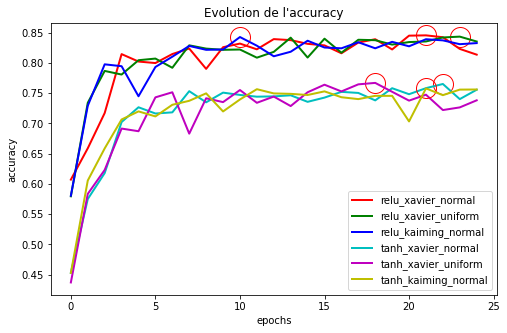

In [34]:
from turtle import color


total_accs = {'relu_xavier_normal': [0.6072, 0.659, 0.7173, 0.8147, 0.8024, 0.7999, 0.8148, 0.8239, 0.7903, 0.8261, 0.8321, 0.8226, 0.8395, 0.8378, 0.8317, 0.8291, 0.8161, 0.8338, 0.8393, 0.8224, 0.8452, 0.8457, 0.8426, 0.8233, 0.8138], 'relu_xavier_uniform': [0.5796, 0.7342, 0.7869, 0.7809, 0.8046, 0.8073, 0.7921, 0.8292, 0.8238, 0.8218, 0.8223, 0.8088, 0.8184, 0.8419, 0.809, 0.8402, 0.817, 0.8384, 0.8377, 0.8304, 0.8346, 0.8356, 0.8422, 0.8436, 0.8355], 'relu_kaiming_normal': [0.5807, 0.7293, 0.7978, 0.7947, 0.745, 0.7934, 0.8104, 0.8282, 0.8218, 0.8223, 0.8429, 0.8286, 0.8111, 0.8186, 0.8368, 0.8256, 0.8243, 0.8343, 0.8243, 0.835, 0.8276, 0.8393, 0.8374, 0.8311, 0.8329], 'tanh_xavier_normal': [0.4532, 0.5751, 0.618, 0.7024, 0.7268, 0.7165, 0.7184, 0.7534, 0.735, 0.751, 0.7472, 0.7443, 0.7448, 0.7466, 0.7358, 0.7428, 0.7523, 0.7505, 0.7382, 0.7583, 0.7484, 0.7584, 0.7653, 0.7403, 0.7558], 'tanh_xavier_uniform': [0.4372, 0.5836, 0.6232, 0.6916, 0.6872, 0.7432, 0.7516, 0.6832, 0.7417, 0.7353, 0.7553, 0.7342, 0.7445, 0.7288, 0.7516, 0.7641, 0.753, 0.7647, 0.7671, 0.7524, 0.7378, 0.7476, 0.7222, 0.7266, 0.7383], 'tanh_kaiming_normal': [0.453, 0.6057, 0.6588, 0.7066, 0.72, 0.7117, 0.7309, 0.7375, 0.7498, 0.7199, 0.7397, 0.7567, 0.7497, 0.749, 0.7471, 0.7531, 0.7434, 0.7403, 0.7457, 0.7457, 0.7034, 0.758, 0.7468, 0.756, 0.7562]}
total_loss = {'relu_xavier_normal': [1.126641263690176, 1.044066513640971, 0.852560623537136, 0.5585378231127051, 0.6237208054790014, 0.6530190389367598, 0.6407412369794483, 0.656485832944701, 0.9232006012638913, 0.7776384945911697, 0.705296799729142, 0.7983642699597757, 0.7501004304312453, 0.7165294953539402, 0.7605531845666185, 0.8135541141787662, 0.9629606317870224, 0.8278005707867538, 0.7952847016763084, 0.9610866081865528, 0.807451770275454, 0.7906854197948794, 0.8049903915652746, 0.9903973688053179, 1.0378625543811653], 'relu_xavier_uniform': [1.2108347619636148, 0.776341503179526, 0.6217844893660727, 0.6631156240082994, 0.6326466315909277, 0.641730510358569, 0.731069729297976, 0.6173864987832082, 0.7065721437146392, 0.7497620307192018, 0.7599751934220519, 0.8689051953297627, 0.8612581053866616, 0.7373612360863746, 0.9951001564158669, 0.7473207044450543, 0.9697335664230057, 0.8027798618319668, 0.8401052227503136, 0.8879865528661993, 0.8571655342850504, 0.8810786057876635, 0.8274167108384869, 0.8331018267553064, 0.8641215140306497], 'relu_kaiming_normal': [1.2730404380001599, 0.7789776687380634, 0.5945973456660404, 0.6188949289955671, 0.8725842328011235, 0.6902817532986025, 0.6757924424696572, 0.6389549517933326, 0.7359985682783248, 0.7468741732307628, 0.7011420847494391, 0.7953857100462611, 0.9316018899030323, 0.8910956288440318, 0.8106381493278697, 0.9084642540804947, 0.9012255661095245, 0.8077468294886094, 0.9137532228155981, 0.8611276957053172, 0.9409955947459498, 0.8539977345285537, 0.885504035255577, 0.9459784826900386, 0.9151209781441507], 'tanh_xavier_normal': [1.538969095749191, 1.1681634595122519, 1.0613214200056051, 0.8454762123808076, 0.7848555551299566, 0.8280752799178981, 0.872780519950239, 0.7785018392001526, 0.8875920402852795, 0.8404144093960146, 0.8799519965165779, 0.9850345766997035, 1.0952994763096677, 1.1520325549041168, 1.2274324667604664, 1.2485079712505582, 1.2092738672147822, 1.2112653938275348, 1.368123078648048, 1.2314614004726652, 1.2961153342754026, 1.2515118114555939, 1.2213646694074702, 1.489651005479354, 1.3395114669316932], 'tanh_xavier_uniform': [1.5562924146652222, 1.1579936742782593, 1.0624307016783123, 0.8779455015930948, 0.8746172974381266, 0.7509086403665663, 0.7146756147282033, 1.0422377526005613, 0.8377970287316963, 0.9207446876960464, 0.8904283733307561, 1.07885286174243, 1.0233393756649163, 1.193832573256915, 1.12277415885201, 1.1054509455644632, 1.1058337220662757, 1.117202272143545, 1.1579904292203202, 1.2482453350779377, 1.4337214314484898, 1.31652662044839, 1.6266701538351518, 1.5754337129713614, 1.4788974568813662], 'tanh_kaiming_normal': [1.5006631959842731, 1.0696758235557169, 0.9396715662147426, 0.8182094082047667, 0.8051500780672967, 0.8424757100358794, 0.7874026762533791, 0.8484474126296707, 0.8428913641579544, 1.100597797315332, 1.0312462298175957, 1.0300495149214057, 1.0770998959299884, 1.1554059846491753, 1.1485753255554392, 1.19600313222861, 1.303202087177506, 1.3551394630082045, 1.2457236587246763, 1.3635198406026334, 1.6462902524803258, 1.3042156251170967, 1.3176278517216067, 1.3261993391604363, 1.3846288896814178]}

#print minimum of dictionary total_accs
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
cpt_color = 0
for i in total_accs:
    print(i, max(total_accs[i]), np.argmax(total_accs[i]))
    plt.plot(np.argmax(total_accs[i]), max(total_accs[i]),marker="o", markersize=20, markeredgecolor="red", markerfacecolor="None")
    plt.plot(total_accs[i], label = i, linewidth=2, color=colors[cpt_color])
    plt.xlabel("epochs")
    plt.ylabel('accuracy')
    plt.legend()
    plt.title("Evolution de l'accuracy")
    cpt_color += 1
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

relu_xavier_normal 0.5585378231127051 3
relu_xavier_uniform 0.6173864987832082 7
relu_kaiming_normal 0.5945973456660404 2
tanh_xavier_normal 0.7785018392001526 7
tanh_xavier_uniform 0.7146756147282033 6
tanh_kaiming_normal 0.7874026762533791 6


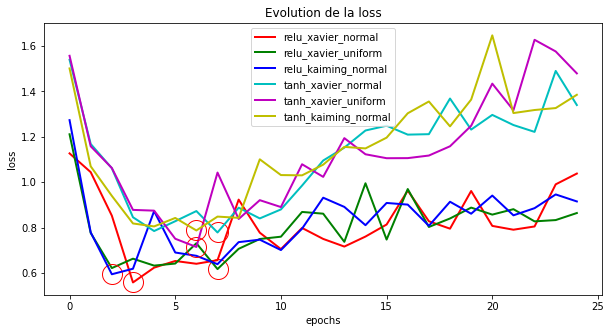

In [36]:
cpt_color = 0
for i in total_loss:
    print(i, min(total_loss[i]), np.argmin(total_loss[i]))
    plt.plot(np.argmin(total_loss[i]), min(total_loss[i]),marker="o", markersize=20, markeredgecolor="red", markerfacecolor="None")
    plt.plot(total_loss[i], label = i, linewidth=2, color=colors[cpt_color])
    plt.xlabel("epochs")
    plt.ylabel('loss')
    plt.legend()
    plt.title("Evolution de la loss")
    cpt_color += 1
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

In [5]:
total_accs = {'relu_xavier_normal': [0.6072, 0.659, 0.7173, 0.8147, 0.8024, 0.7999, 0.8148, 0.8239, 0.7903, 0.8261, 0.8321, 0.8226, 0.8395, 0.8378, 0.8317, 0.8291, 0.8161, 0.8338, 0.8393, 0.8224, 0.8452, 0.8457, 0.8426, 0.8233, 0.8138], 'relu_xavier_uniform': [0.5796, 0.7342, 0.7869, 0.7809, 0.8046, 0.8073, 0.7921, 0.8292, 0.8238, 0.8218, 0.8223, 0.8088, 0.8184, 0.8419, 0.809, 0.8402, 0.817, 0.8384, 0.8377, 0.8304, 0.8346, 0.8356, 0.8422, 0.8436, 0.8355], 'relu_kaiming_normal': [0.5807, 0.7293, 0.7978, 0.7947, 0.745, 0.7934, 0.8104, 0.8282, 0.8218, 0.8223, 0.8429, 0.8286, 0.8111, 0.8186, 0.8368, 0.8256, 0.8243, 0.8343, 0.8243, 0.835, 0.8276, 0.8393, 0.8374, 0.8311, 0.8329], 'tanh_xavier_normal': [0.4532, 0.5751, 0.618, 0.7024, 0.7268, 0.7165, 0.7184, 0.7534, 0.735, 0.751, 0.7472, 0.7443, 0.7448, 0.7466, 0.7358, 0.7428, 0.7523, 0.7505, 0.7382, 0.7583, 0.7484, 0.7584, 0.7653, 0.7403, 0.7558], 'tanh_xavier_uniform': [0.4372, 0.5836, 0.6232, 0.6916, 0.6872, 0.7432, 0.7516, 0.6832, 0.7417, 0.7353, 0.7553, 0.7342, 0.7445, 0.7288, 0.7516, 0.7641, 0.753, 0.7647, 0.7671, 0.7524, 0.7378, 0.7476, 0.7222, 0.7266, 0.7383], 'tanh_kaiming_normal': [0.453, 0.6057, 0.6588, 0.7066, 0.72, 0.7117, 0.7309, 0.7375, 0.7498, 0.7199, 0.7397, 0.7567, 0.7497, 0.749, 0.7471, 0.7531, 0.7434, 0.7403, 0.7457, 0.7457, 0.7034, 0.758, 0.7468, 0.756, 0.7562]}
total_loss = {'relu_xavier_normal': [1.126641263690176, 1.044066513640971, 0.852560623537136, 0.5585378231127051, 0.6237208054790014, 0.6530190389367598, 0.6407412369794483, 0.656485832944701, 0.9232006012638913, 0.7776384945911697, 0.705296799729142, 0.7983642699597757, 0.7501004304312453, 0.7165294953539402, 0.7605531845666185, 0.8135541141787662, 0.9629606317870224, 0.8278005707867538, 0.7952847016763084, 0.9610866081865528, 0.807451770275454, 0.7906854197948794, 0.8049903915652746, 0.9903973688053179, 1.0378625543811653], 'relu_xavier_uniform': [1.2108347619636148, 0.776341503179526, 0.6217844893660727, 0.6631156240082994, 0.6326466315909277, 0.641730510358569, 0.731069729297976, 0.6173864987832082, 0.7065721437146392, 0.7497620307192018, 0.7599751934220519, 0.8689051953297627, 0.8612581053866616, 0.7373612360863746, 0.9951001564158669, 0.7473207044450543, 0.9697335664230057, 0.8027798618319668, 0.8401052227503136, 0.8879865528661993, 0.8571655342850504, 0.8810786057876635, 0.8274167108384869, 0.8331018267553064, 0.8641215140306497], 'relu_kaiming_normal': [1.2730404380001599, 0.7789776687380634, 0.5945973456660404, 0.6188949289955671, 0.8725842328011235, 0.6902817532986025, 0.6757924424696572, 0.6389549517933326, 0.7359985682783248, 0.7468741732307628, 0.7011420847494391, 0.7953857100462611, 0.9316018899030323, 0.8910956288440318, 0.8106381493278697, 0.9084642540804947, 0.9012255661095245, 0.8077468294886094, 0.9137532228155981, 0.8611276957053172, 0.9409955947459498, 0.8539977345285537, 0.885504035255577, 0.9459784826900386, 0.9151209781441507], 'tanh_xavier_normal': [1.538969095749191, 1.1681634595122519, 1.0613214200056051, 0.8454762123808076, 0.7848555551299566, 0.8280752799178981, 0.872780519950239, 0.7785018392001526, 0.8875920402852795, 0.8404144093960146, 0.8799519965165779, 0.9850345766997035, 1.0952994763096677, 1.1520325549041168, 1.2274324667604664, 1.2485079712505582, 1.2092738672147822, 1.2112653938275348, 1.368123078648048, 1.2314614004726652, 1.2961153342754026, 1.2515118114555939, 1.2213646694074702, 1.489651005479354, 1.3395114669316932], 'tanh_xavier_uniform': [1.5562924146652222, 1.1579936742782593, 1.0624307016783123, 0.8779455015930948, 0.8746172974381266, 0.7509086403665663, 0.7146756147282033, 1.0422377526005613, 0.8377970287316963, 0.9207446876960464, 0.8904283733307561, 1.07885286174243, 1.0233393756649163, 1.193832573256915, 1.12277415885201, 1.1054509455644632, 1.1058337220662757, 1.117202272143545, 1.1579904292203202, 1.2482453350779377, 1.4337214314484898, 1.31652662044839, 1.6266701538351518, 1.5754337129713614, 1.4788974568813662], 'tanh_kaiming_normal': [1.5006631959842731, 1.0696758235557169, 0.9396715662147426, 0.8182094082047667, 0.8051500780672967, 0.8424757100358794, 0.7874026762533791, 0.8484474126296707, 0.8428913641579544, 1.100597797315332, 1.0312462298175957, 1.0300495149214057, 1.0770998959299884, 1.1554059846491753, 1.1485753255554392, 1.19600313222861, 1.303202087177506, 1.3551394630082045, 1.2457236587246763, 1.3635198406026334, 1.6462902524803258, 1.3042156251170967, 1.3176278517216067, 1.3261993391604363, 1.3846288896814178]}
for i in total_accs:
    print(i, total_accs[i][-1])
for i in total_loss:
    print(i, total_loss[i][-1])

relu_xavier_normal 0.8138
relu_xavier_uniform 0.8355
relu_kaiming_normal 0.8329
tanh_xavier_normal 0.7558
tanh_xavier_uniform 0.7383
tanh_kaiming_normal 0.7562
relu_xavier_normal 1.0378625543811653
relu_xavier_uniform 0.8641215140306497
relu_kaiming_normal 0.9151209781441507
tanh_xavier_normal 1.3395114669316932
tanh_xavier_uniform 1.4788974568813662
tanh_kaiming_normal 1.3846288896814178
